# Load Data and Show Some Samples

In [19]:
import torch
from datasets import SequenceDataset
from torchvision.transforms import v2, InterpolationMode
from modules.ego_motion_filter import EgoMotionFilter
from modules.geometry_filter import GeometryFilter
from modules.segmentation_model import SegmentationModel
from modules.identity import Identity
import util
import sequence_segmenter
from visualizations.save_gif import save_tensors_as_gif
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
root_dir = "/home/nfs/inf6/data/datasets/Carla_Moritz/SyncAngel3/"

transforms = v2.Compose([
    v2.Resize((256, 512), InterpolationMode.BILINEAR, antialias=False),
    v2.ToDtype(torch.float, scale=True),
])


test_dataset = SequenceDataset(root_dir, transform=transforms, split='test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)

## Show Some Samples

In [3]:
import visualizations.segmentation_utils as segmentation_utils
import matplotlib.pyplot as plt

image, seg, depth, position = next(iter(test_loader))
#image, seg, depth = image[0,0,...], seg[0,0,...], depth[0,0,...]

In [4]:
positions_list = torch.unbind_copy(position[0][0:6], 0)
positions_list = [p.numpy() for p in positions_list]

In [5]:
from visualizations.visualize_camera_poses import visualize_camera_positions

initialize camera pose visualizer


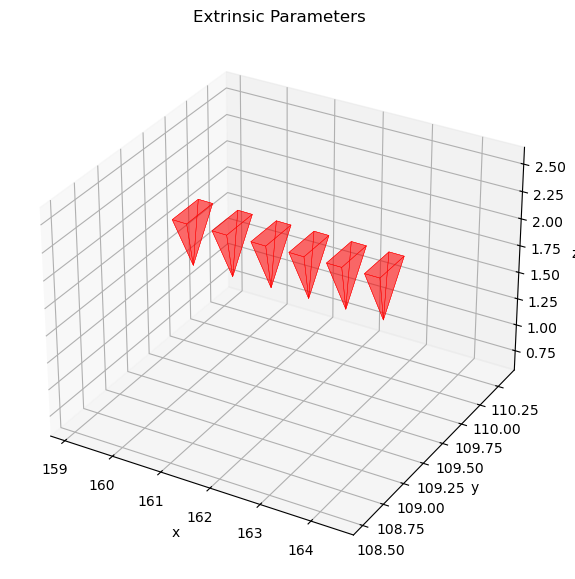

In [6]:
visualize_camera_positions(positions_list)

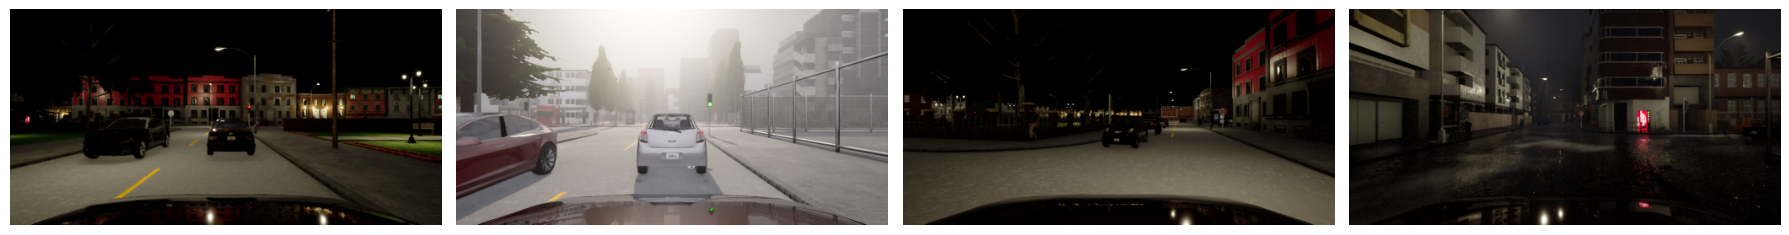

In [8]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(18, 5)
for i in range(4):
    ax[i].imshow(image[i][0].cpu().permute(1,2,0))
    ax[i].axis("off")
plt.tight_layout()
plt.show()


# Load pretrained model 

In [9]:
geometry_filter = GeometryFilter(use_cuda=True).to(device)
ego_motion = EgoMotionFilter().to(device)
#util.load_model('models/finetune_ep_0.pth', geometry_filter=geometry_filter, ego_motion=ego_motion)
util.load_model('models/sequence_ep_6.pth', geometry_filter=geometry_filter, ego_motion=ego_motion)

naive_model = SegmentationModel(Identity())
checkpoint = torch.load('models/checkpoint_epoch_10.pth')
naive_model.load_state_dict(checkpoint['model_state_dict'])
naive_model.to(device)
del checkpoint

## Display the Structure

In [10]:
geometry_filter.eval()

GeometryFilter(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

In [8]:
ego_motion.eval()

EgoMotionFilter(
  (motion_estimator): MotionEstimator(
    (layer1): Sequential(
      (0): Conv2d(4096, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (avg_pooling): AvgPool2d(kernel_size=(4, 8), stride=(4, 8), padding=0)
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rnn): GRUCell(128, 128)
  (camera_head):

## Statistics

In [9]:
from util import count_model_params

count_model_params(geometry_filter)

273359575

In [10]:
count_model_params(ego_motion)

40540550

# Qualitative results

## Frame-By-Frame Baseline

In [11]:
# Show results on at least 5 sequences
pred_segs = sequence_segmenter.process_video_framewise(image, naive_model, device)

In [12]:
#Sequence 1
for i in range(5):
    save_tensors_as_gif(pred_segs[i], f'images/naive_seg_{i}.gif', segmentation=True)

![naive0](images/naive_seg_0.gif)

![naive1](images/naive_seg_1.gif)

![native2](images/naive_seg_2.gif)

![naive3](images/naive_seg_3.gif)

![naive4](images/naive_seg_4.gif)

## End-to-End Approach

In [12]:
# Show results on at least 5 sequences
pred_segs, pred_depths, pred_transforms = sequence_segmenter.process_video(image, model=geometry_filter, ego_motion=ego_motion, device=device)

#Sequence 1
for i in range(5):
    save_tensors_as_gif(pred_segs[i], f'images/endtoend_seg_{i}.gif', segmentation=True)
    save_tensors_as_gif(pred_depths[i], f'images/endtoend_dep_{i}.gif')

![end to end 0](images/endtoend_seg_0.gif)

![end to end 1](images/endtoend_seg_1.gif)

![end to end 2](images/endtoend_seg_2.gif)

![end to end 3](images/endtoend_seg_3.gif)

![end to end 4](images/endtoend_seg_4.gif)

## RGB and Semantic Point Clouds
First we export the needed depth, segmentations, and RGB

In [29]:
from visualizations.save_image import save_image
from visualizations.segmentation_utils import draw_segmentation_map
from imageio import imsave

# Visualize RGB and semantic point-clouds (use depth, camera poses and intrinsics)
np.save('export/depth1', pred_depths[0][0].cpu().permute(1,2,0).numpy().squeeze())
np.save('export/depth2', pred_depths[1][0].cpu().permute(1,2,0).numpy().squeeze())
imsave('export/seg1.jpg', draw_segmentation_map(pred_segs[0][0].softmax(dim=-3)))
imsave('export/seg2.jpg', draw_segmentation_map(pred_segs[1][0].softmax(dim=-3)))
save_image(image[0][0], 'export/rgb1.jpg')
save_image(image[1][0], 'export/rgb2.jpg')
np.save('export/depth1a', depth[0][0].cpu().permute(1,2,0).numpy().squeeze())
np.save('export/depth2a', depth[1][0].cpu().permute(1,2,0).numpy().squeeze())

Honestly, our depth head wasn't particularly effective, so we provide here the segmantic point cloud with the given depth data

![Point cloud 1](images/pointcloud1.png)

![Point cloud 2](images/pointcloud2.png)

## Visualizing Cramera Poses

initialize camera pose visualizer


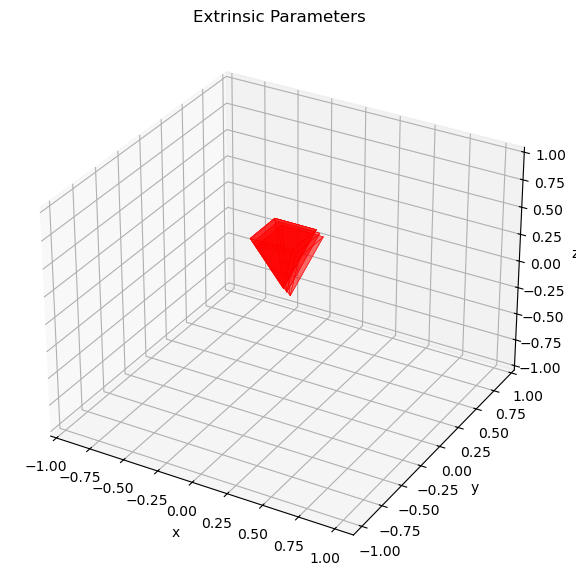

In [15]:
from visualizations.visualize_camera_poses import visualize_camera_transformations
visualize_camera_transformations([p.cpu().numpy() for p in pred_transforms[0].unbind()])

initialize camera pose visualizer


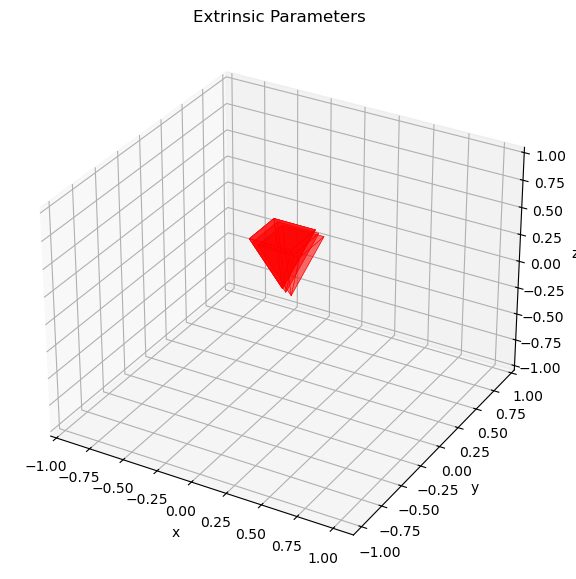

In [16]:
visualize_camera_transformations([p.cpu().numpy() for p in pred_transforms[1].unbind()])

initialize camera pose visualizer


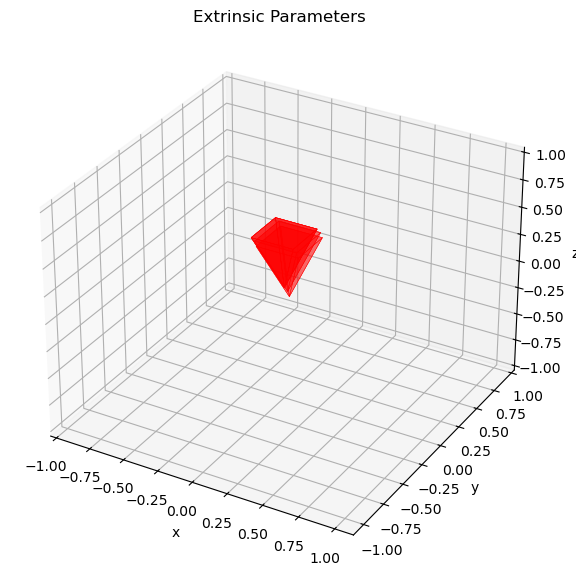

In [17]:
visualize_camera_transformations([p.cpu().numpy() for p in pred_transforms[2].unbind()])

# Quantitative evaluation

In [10]:
from sequence_trainer import eval_model

loss, (avg_accuracy, mIoU) = eval_model(
        model=geometry_filter, ego_motion=ego_motion, eval_loader=test_loader,
        device=device, epoch=1, writer=None)

print(f'Average loss: {loss}, Average accuracy: {avg_accuracy}, Average IoU {mIoU}')

Epoch 2: seg_loss 0.51351, depth_loss 0.00007, pos_loss 3.01249: 100%|██████████| 188/188 [12:48<00:00,  4.09s/it] 

Average loss: 0.5584785222930682, Average accuracy: 83.6943835788303, Average IoU 0.3575233221054077
